In [185]:
# importing core libraries and loading dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("ready_data.csv")
df = df.drop("Unnamed: 0", axis=1) # deleting column with old indexes
df.head()

,Y,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,education,income,direction_same,occupation_grouped,toCoupon_distance,visit_freq,temp_outside
0,1,Alone,Good,2PM,Restaurant(<20),1d,Male,21-30,Single,0,High,2,0,Tech_Eng,1,3,Cold
1,0,Friend(s),Good,10AM,Coffee House,2h,Male,21-30,Single,0,High,2,0,Tech_Eng,1,1,Warm
2,1,Friend(s),Good,10AM,Bar,1d,Male,21-30,Single,0,High,2,0,Tech_Eng,1,0,Warm
3,0,Friend(s),Good,10AM,Carry out & Take away,2h,Male,21-30,Single,0,High,2,0,Tech_Eng,2,3,Warm
4,0,Friend(s),Good,2PM,Coffee House,1d,Male,21-30,Single,0,High,2,0,Tech_Eng,1,1,Warm


In [186]:
df_model = df.copy()

# **1. Dataset Partitioning and One-Hot Encoding** 

In [187]:
# defining the target variable and predictors

X = df_model.drop(['Y'], axis = 1)
y = df_model['Y']

In [188]:
# One-Hot Encoding (all features treated as nominal)
# An alternative approach with some features (such as, "age", "education", "income", "visit_freq") treated as ordinal was also tested. 
# Since performance differences were minor, only the nominal encoding version is presented below.

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

onehot_encoder = OneHotEncoder(drop='first', sparse_output=False) # spare = False

In [189]:
preprocessor = ColumnTransformer(transformers=[('onehot', onehot_encoder, X.columns)])

In [190]:
# splitting the data into training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [191]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [192]:
# training set preview

feature_names = preprocessor.get_feature_names_out()
df_model_processed = pd.DataFrame(X_train_processed, columns=feature_names)
df_model_processed.head(10)

,onehot__passanger_Friend(s),onehot__passanger_Kid(s),onehot__passanger_Partner,onehot__weather_Good,onehot__time_10PM,onehot__time_2PM,onehot__time_6PM,onehot__time_7AM,onehot__coupon_Carry out & Take away,onehot__coupon_Coffee House,...,onehot__occupation_grouped_Social_Edu,onehot__occupation_grouped_Student,onehot__occupation_grouped_Tech_Eng,onehot__occupation_grouped_Unemployed,onehot__toCoupon_distance_2,onehot__toCoupon_distance_3,onehot__visit_freq_1,onehot__visit_freq_2,onehot__visit_freq_3,onehot__temp_outside_Warm
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
5,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [193]:
df_model_processed.shape

(8455, 38)

# **2. Model Building and Evaluation**

In [194]:
# Function for model evaluation (metrics: F1-Score, accuracy, ROC-AUC)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred_class = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_class))
    print("F1-Score:", f1_score(y_test, y_pred_class))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print(classification_report(y_test, y_pred_class))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_test, y_pred_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--',alpha=0.6)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [195]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay

## **2.1. Logistic Regression**

### **2.1.1. Model Training & Tuning & Evaluation**

In [196]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr_pipe = Pipeline([('pre', preprocessor),('lr', lr)])

In [197]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_outside'],
      dtype='object'))])),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

#### **Parameter Tuning**: GridSearch and Randomized Search were used to tune the parameters of the logistic regression model. The results were similar. Randomized Search was used for the remaining models to maintain consistency.

In [198]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# GridSearch

param_grid = {'lr__C': [0.01, 0.1, 1, 10, 100],
              'lr__penalty': ['l1','l2'],
              'lr__solver': ['liblinear']}

grid_lr = GridSearchCV(lr_pipe, param_grid, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)

print("Best parameters:", grid_lr.best_params_)
print("Best F1-Score (CV):",grid_lr.best_score_)

Best parameters: {'lr__C': 100, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best F1-Score (CV): 0.7587846917477636


In [199]:
# RandomizedSearch

param_dist = {'lr__C': np.logspace(-3, 2, 100),
              'lr__penalty': ['l1', 'l2'],
              'lr__solver': ['liblinear']}

random_search_lr = RandomizedSearchCV(lr_pipe, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1', random_state=42)
random_search_lr.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1-Score (CV):", random_search.best_score_)

Best parameters: {'lr__solver': 'liblinear', 'lr__penalty': 'l1', 'lr__C': 1.7073526474706904}
Best F1-Score (CV): 0.7590005749869917


In [200]:
best_lr_pipe = random_search_lr.best_estimator_

=== Logistic Regression ===
Accuracy: 0.7075055187637969
F1-Score: 0.7593097184377838
ROC-AUC: 0.7571854164285516
              precision    recall  f1-score   support

           0       0.69      0.58      0.63      1543
           1       0.72      0.80      0.76      2081

    accuracy                           0.71      3624
   macro avg       0.70      0.69      0.69      3624
weighted avg       0.71      0.71      0.70      3624



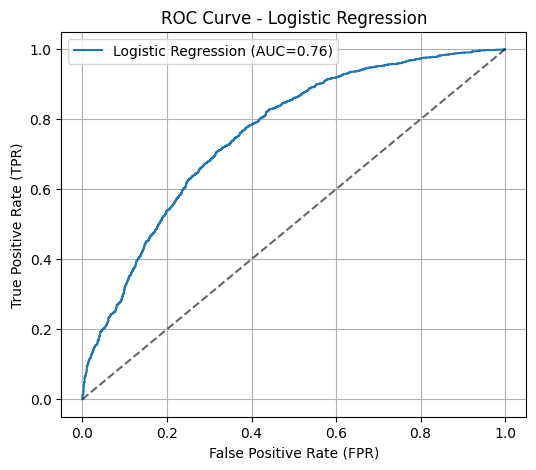

In [201]:
# model evaluation

evaluate_model(best_lr_pipe, X_test, y_test, model_name="Logistic Regression")

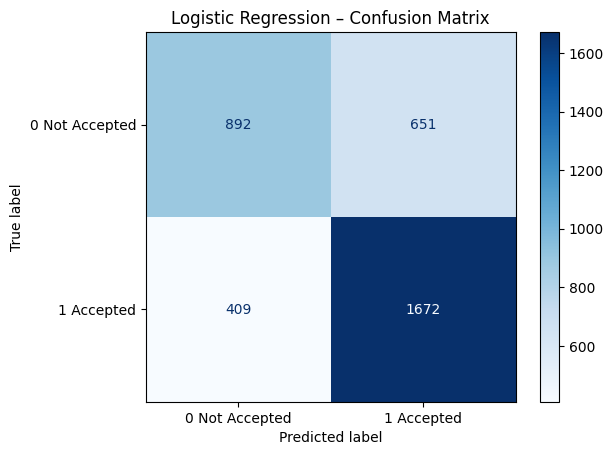

In [202]:
# Confusion matrix - visualization

y_pred = best_lr_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['0 Not Accepted','1 Accepted']).plot(cmap='Blues')
plt.title("Logistic Regression – Confusion Matrix")
plt.show()


### **2.1.2. Feature Importance of the Optimal Logistic Regression + Interpretation**

In [203]:
ohe = lr_pipe_best.named_steps['pre'].named_transformers_['onehot']
feature_names = ohe.get_feature_names_out(X.columns)

coefs = lr_pipe_best.named_steps['lr'].coef_[0]


coef_df = pd.DataFrame({ 'Feature': feature_names,
                        'Coefficient': coefs}).sort_values(by='Coefficient', key=np.abs, ascending=False).reset_index()

display(coef_df)

# The coefficient estimates for the features in the model after tuning are presented below. 
# They are sorted from the highest absolute value of the estimates to the lowest.

,index,Feature,Coefficient
0,36,visit_freq_3,2.092155
1,35,visit_freq_2,1.933574
2,34,visit_freq_1,1.363431
3,12,expiration_2h,-0.889442
4,8,coupon_Carry out & Take away,0.739756
5,4,time_10PM,-0.673839
6,0,passanger_Friend(s),0.673448
7,11,coupon_Restaurant(<20),0.588944
8,2,passanger_Partner,0.512828
9,7,time_7AM,-0.497119


### **INTERPRETATION**

#### **The absolute value** of the coefficients indicates **the strength of the variable's influence on the logarithm of the coupon acceptance odds (log-odds)**. The higher the value, the stronger the variable's influence (relative to the reference category).

#### **The sign** before the coefficient value indicates **the direction of the variable's influence on the logarithm of the coupon acceptance odds (log-odds)**. A negative value suggests that the variable (relative to the reference category) has a negative impact.

___



#### The highest absolute coefficient values were obtained for: `visit_freq_3` & `visit_freq_2` & `visit_freq_1`, `expiration_2h`, `coupon_Carry out & Take away`, `time_10PM`, and `passanger_Friend(s)`.

####
#### For example, it follows that:
#### 1) If a driver visits a coupon redemption location on average at least 4 times per month (`visit_freq_3`), **the logarithm of the odds of coupon acceptance** is approximately `2.09 higher` than if the driver does not visit the location at all (visit_freq = 1).

#### Since `exp(2.09) ≈ 8.08`, this means that **the odds of coupon acceptance** in this case are `708% higher`.

#### 2) If the offered coupon expires within 2 hours (`expiration_2h`), **the logarithm of the odds of coupon acceptance** is approximately `0.89 lower` than if it expires the next day (expiration = 1d).

#### Since `exp(-0.89) ≈ 0.41`, this means that **the odds of coupon acceptance** in this case are `59% lower`.

## **2.2. Simple Classification Tree**

### **2.2.1. Model Training & Tuning & Evaluation**

In [204]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt_pipe = Pipeline([('pre', preprocessor),('dt', dt)])


In [205]:
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_outside'],
      dtype='object'))])),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [206]:
param_dist = {'dt__max_depth': [None, 3, 5, 7, 10],
              'dt__min_samples_leaf': [1, 2, 5, 10, 20],
              'dt__min_samples_split': [2, 5, 10, 20],
              'dt__ccp_alpha': np.linspace(0.0, 0.01, 20)}

In [207]:
random_search_dt = RandomizedSearchCV(dt_pipe, 
                                      param_distributions=param_dist,
                                      n_iter=30,
                                      cv=5,
                                      scoring='f1',
                                      n_jobs=-1,
                                      random_state=42)

random_search_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_o...
                   param_distributions={'dt__ccp_alpha': array([0.        , 0.00052632, 0.00105263, 0.00157895, 0.00210526,
       0.00263158, 0.00315789, 0.00368421, 0.00421053, 0.00473684,
       0.00526316, 0.00578947, 0.00631579, 0.00684211, 0.00736842,
       0.00789474, 0.00842105, 0.00894737, 0.00947368, 0.01      ]),
                                        'dt__max_depth': [None, 3, 5, 7, 10],
                                        'dt__min_samples_leaf': [1, 2, 5, 10,
                                                                 20],
                                        'dt__min_samples_split': [2, 5, 10,
                                                                  20]},
                   random_state=42, scoring='f1')

In [208]:
print("Best parameters:", random_search_dt.best_params_)
print("Best F1-Score (CV):", random_search_dt.best_score_)

Best parameters: {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 20, 'dt__max_depth': 5, 'dt__ccp_alpha': 0.0}
Best F1-Score (CV): 0.7529949193194486


In [209]:
best_dt_pipe = random_search_dt.best_estimator_

=== Decision Tree ===
Accuracy: 0.6948123620309051
F1-Score: 0.7625590382138256
ROC-AUC: 0.7421356637515677
              precision    recall  f1-score   support

           0       0.71      0.48      0.57      1543
           1       0.69      0.85      0.76      2081

    accuracy                           0.69      3624
   macro avg       0.70      0.67      0.67      3624
weighted avg       0.70      0.69      0.68      3624



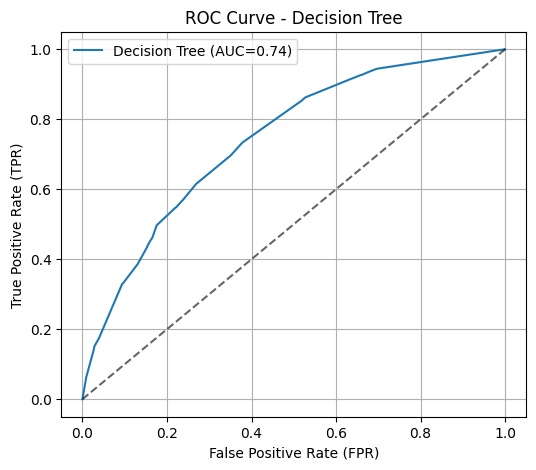

In [210]:
# model evaluation

evaluate_model(best_dt_pipe, X_test, y_test, model_name="Decision Tree")

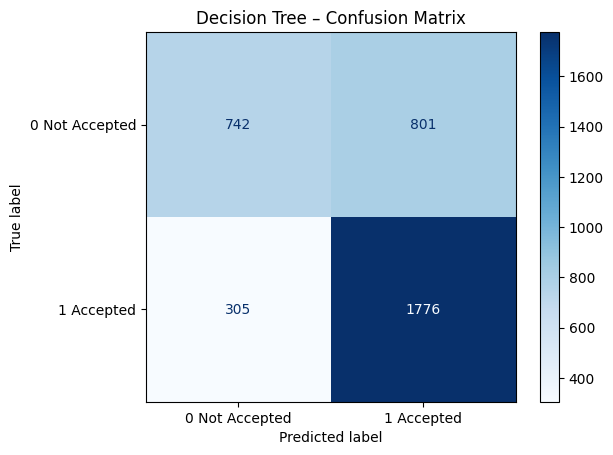

In [211]:
y_pred = best_dt_pipe.predict(X_test)

# Confusion matrix - visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['0 Not Accepted','1 Accepted']).plot(cmap='Blues')
plt.title("Decision Tree – Confusion Matrix")
plt.show()

### **2.2.2. Optimal Tree Visualization**

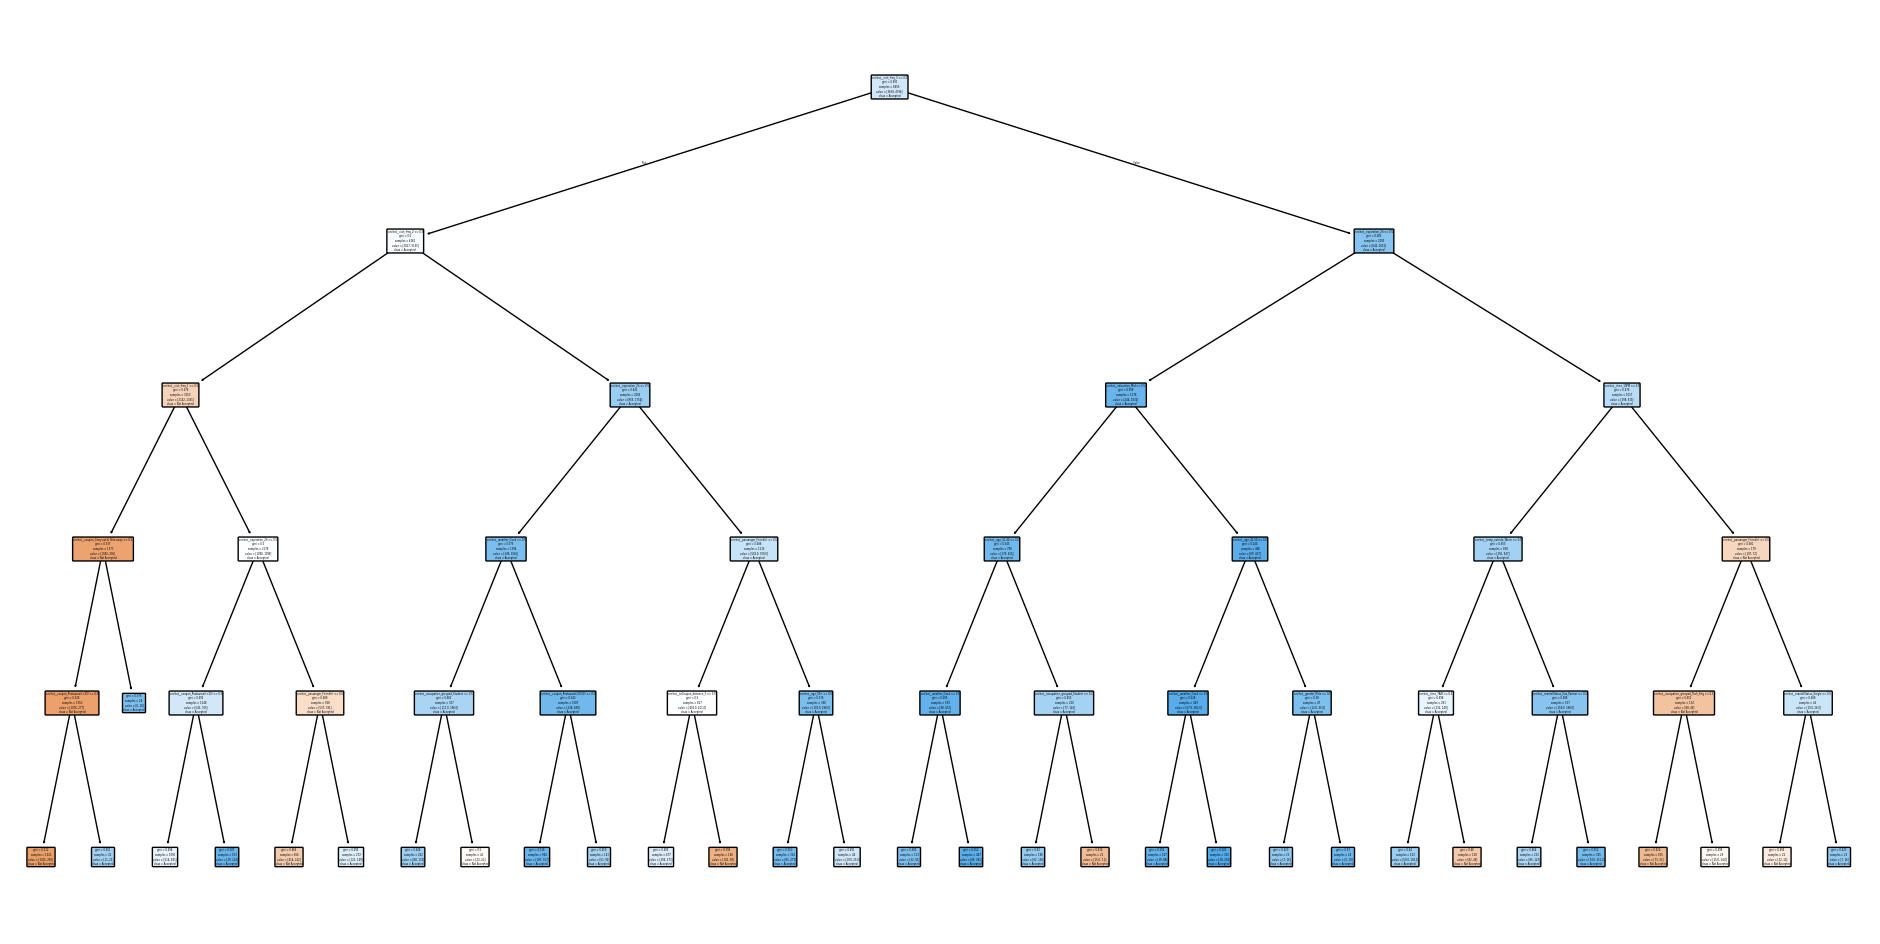

In [212]:
from sklearn.tree import plot_tree

dt_best = best_dt_pipe.named_steps['dt'] 
feature_names = preprocessor.get_feature_names_out()

plt.figure(figsize=(24, 12))
plot_tree(dt_best,
          feature_names=feature_names,
          class_names=['Not Accepted', 'Accepted'],
          filled=True,
          rounded=True)

plt.show()

## **2.3. Random Forest**

### **2.3.1. Model Training & Tuning & Evaluation**

In [213]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_pipe = Pipeline([('pre', preprocessor), ('rf',  rf)])

In [214]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_outside'],
      dtype='object'))])),
                ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [215]:
param_dist = {'rf__n_estimators'   : [100, 200, 300, 400, 500, 600], 
              'rf__max_depth'      : [None, 5, 10, 20],
              'rf__min_samples_leaf': [1, 2, 4],
              'rf__min_samples_split': [2, 5, 10],
              'rf__max_features'   : ['sqrt', 0.3, 0.5],
              'rf__bootstrap'      : [True, False]}

In [216]:
randomsearch_rf = RandomizedSearchCV(rf_pipe,
                                     param_distributions=param_dist,
                                     n_iter=30,              
                                     cv=5,
                                     scoring='f1',
                                     n_jobs=1,
                                     random_state=42,
                                     verbose=1)

randomsearch_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_o...
      dtype='object'))])),
                                             ('rf',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__max_depth': [None, 5, 10, 20],
                                        'rf__max_features': ['sqrt', 0.3, 0.5],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [100, 200, 300, 400,
                                                             500, 600]},
                   random_state=42, scoring='f1', verbose=1)

In [217]:
print("Best parameters:", randomsearch_rf.best_params_)
print("Best F1-Score (CV):", randomsearch_rf.best_score_)

Best parameters: {'rf__n_estimators': 600, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_features': 0.3, 'rf__max_depth': None, 'rf__bootstrap': True}
Best F1-Score (CV): 0.77359609890788


In [218]:
best_rf_pipe = randomsearch_rf.best_estimator_

=== Random Forest ===
Accuracy: 0.7207505518763797
F1-Score: 0.767142199723884
ROC-AUC: 0.7829171004642502
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1543
           1       0.74      0.80      0.77      2081

    accuracy                           0.72      3624
   macro avg       0.72      0.71      0.71      3624
weighted avg       0.72      0.72      0.72      3624



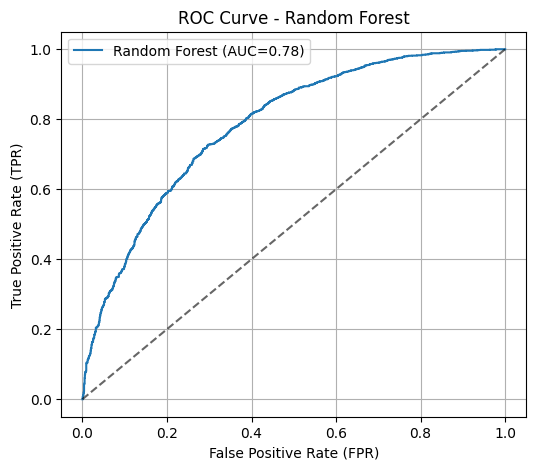

In [219]:
# model evaluation

evaluate_model(best_rf_pipe, X_test, y_test, model_name="Random Forest")

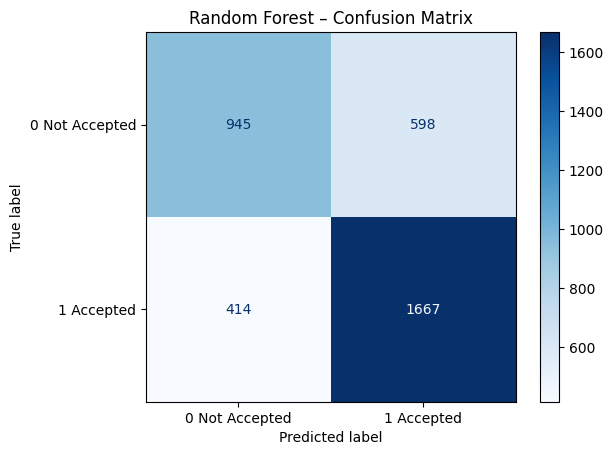

In [220]:
y_pred = best_rf_pipe.predict(X_test)

# Confusion matrix - visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['0 Not Accepted','1 Accepted']).plot(cmap='Blues')
plt.title("Random Forest – Confusion Matrix")
plt.show()

### **2.3.2. Features Importances of the Optimal Forest**

In [221]:
feature_names = best_rf_pipe.named_steps['pre'].get_feature_names_out()

imp = pd.Series(best_rf_pipe.named_steps['rf'].feature_importances_,index=feature_names).sort_values(ascending=False)

print("\n 15 Top Features - Random Forest:")
display(imp.head(15))


 15 Top Features - Random Forest:


onehot__visit_freq_3                    0.083006
onehot__visit_freq_2                    0.076260
onehot__expiration_2h                   0.055200
onehot__coupon_Carry out & Take away    0.053692
onehot__visit_freq_1                    0.050354
onehot__coupon_Restaurant(<20)          0.048981
onehot__gender_Male                     0.036453
onehot__education_Mid                   0.035508
onehot__passanger_Friend(s)             0.030547
onehot__has_children_1                  0.028022
onehot__toCoupon_distance_2             0.027609
onehot__temp_outside_Warm               0.026417
onehot__age_31-40                       0.025781
onehot__weather_Good                    0.025412
onehot__income_2                        0.024569
dtype: float64

## **2.4. Gradient Boosting**

### **2.4.1. Model Training & Tuning & Evaluation**

In [222]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)

gb_pipe = Pipeline([('pre', preprocessor),('gb',  gb)])

In [223]:
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_outside'],
      dtype='object'))])),
                ('gb', GradientBoostingClassifier(random_state=42))])

In [224]:
param_dist = {'gb__n_estimators'  : [100,200,300,400,500,600],
              'gb__learning_rate' : np.logspace(-3, -0.5, 8), 
              'gb__max_depth'     : [None, 3, 5, 10, 20],
              'gb__subsample'     : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'gb__min_samples_leaf'  : [1, 2, 4],
              'gb__min_samples_split' : [2, 5, 10]}

In [225]:
randomsearch_gb = RandomizedSearchCV(gb_pipe,
                                     param_distributions=param_dist,
                                     n_iter=30,            
                                     cv=5,
                                     scoring='f1',
                                     n_jobs=1,             
                                     random_state=42,
                                     verbose=1)

randomsearch_gb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_o...
                   param_distributions={'gb__learning_rate': array([0.001     , 0.00227585, 0.00517947, 0.01178769, 0.02682696,
       0.06105402, 0.13894955, 0.31622777]),
                                        'gb__max_depth': [None, 3, 5, 10, 20],
                                        'gb__min_samples_leaf': [1, 2, 4],
                                        'gb__min_samples_split': [2, 5, 10],
                                        'gb__n_estimators': [100, 200, 300, 400,
                                                             500, 600],
                                        'gb__subsample': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [227]:
print("Best parameters:", randomsearch_gb.best_params_)
print("Best F1-Score (CV):", randomsearch_gb.best_score_)

Best parameters: {'gb__subsample': 0.2, 'gb__n_estimators': 400, 'gb__min_samples_split': 5, 'gb__min_samples_leaf': 4, 'gb__max_depth': 20, 'gb__learning_rate': 0.0022758459260747888}
Best F1-Score (CV): 0.781622277888802


In [228]:
best_gb_pipe = randomsearch_gb.best_estimator_

=== Gradient Boosting ===
Accuracy: 0.7193708609271523
F1-Score: 0.7753479125248509
ROC-AUC: 0.7832447259920094
              precision    recall  f1-score   support

           0       0.72      0.55      0.63      1543
           1       0.72      0.84      0.78      2081

    accuracy                           0.72      3624
   macro avg       0.72      0.70      0.70      3624
weighted avg       0.72      0.72      0.71      3624



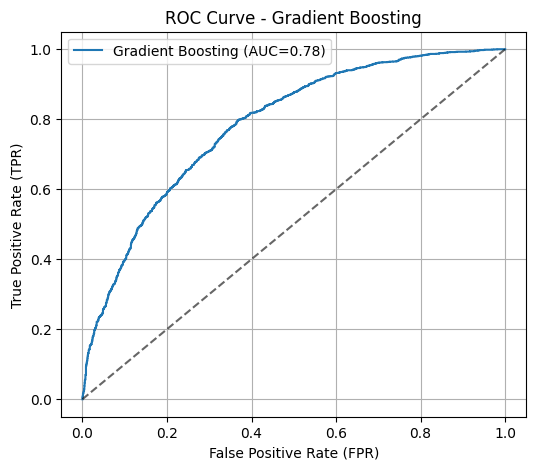

In [229]:
# model evaluation

evaluate_model(best_gb_pipe, X_test, y_test, model_name="Gradient Boosting")

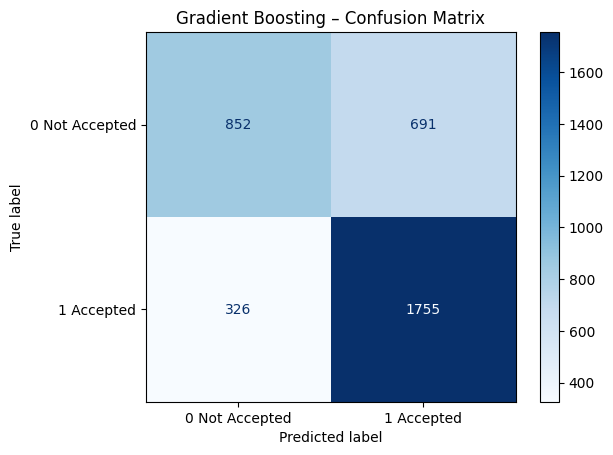

In [230]:
y_pred = best_gb_pipe.predict(X_test)

# Confusion matrix - visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['0 Not Accepted','1 Accepted']).plot(cmap='Blues')
plt.title("Gradient Boosting – Confusion Matrix")
plt.show()

## **2.5. XGBoost**

### **2.5.1. Model Training & Tuning & Evaluation**

In [231]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

xgb_pipe = Pipeline([('pre', preprocessor),('xgb', xgb)])

In [232]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_outside'],
      dtype='object'))])),
                ('xgb...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [233]:
param_dist = {'xgb__n_estimators':    [100, 200, 300, 400, 500, 600],
              'xgb__learning_rate':   [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
              'xgb__max_depth':       [None, 3, 5, 10,20],
              'xgb__subsample':       [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'xgb__colsample_bytree':[0.6, 0.8, 1.0],
              'xgb__gamma':           [0, 1, 5],
              'xgb__reg_lambda':      [0, 0.5, 1.0],
              'xgb__reg_alpha':       [0, 0.5, 1.0]}

In [234]:
randomsearch_xgb = RandomizedSearchCV(xgb_pipe,
                                      param_distributions=param_dist,
                                      n_iter=30,               
                                      cv=5,
                                      scoring='f1',
                                      n_jobs=1,                 
                                      verbose=1,
                                      random_state=42)

randomsearch_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_o...
                   param_distributions={'xgb__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'xgb__gamma': [0, 1, 5],
                                        'xgb__learning_rate': [0.01, 0.05, 0.1,
                                                               0.2, 0.3, 0.5],
                                        'xgb__max_depth': [None, 3, 5, 10, 20],
                                        'xgb__n_estimators': [100, 200, 300,
                                                              400, 500, 600],
                                        'xgb__reg_alpha': [0, 0.5, 1.0],
                                        'xgb__reg_lambda': [0, 0.5, 1.0],
                                        'xgb__subsample': [0.1, 0.2, 0.3, 0.4,
                                                           0.5, 0.6, 0.7, 0.8,
                                                           0.9, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [235]:
print("Best parameters:", randomsearch_xgb.best_params_)
print("Best F1-Score (CV):", randomsearch_xgb.best_score_)

Best parameters: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 1.0, 'xgb__reg_alpha': 1.0, 'xgb__n_estimators': 200, 'xgb__max_depth': 20, 'xgb__learning_rate': 0.1, 'xgb__gamma': 5, 'xgb__colsample_bytree': 1.0}
Best F1-Score (CV): 0.7802453711845085


In [236]:
best_xgb_pipe = randomsearch_xgb.best_estimator_

=== XGBoost ===
Accuracy: 0.727924944812362
F1-Score: 0.77207582061951
ROC-AUC: 0.7941631892787971
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      1543
           1       0.74      0.80      0.77      2081

    accuracy                           0.73      3624
   macro avg       0.72      0.71      0.72      3624
weighted avg       0.73      0.73      0.73      3624



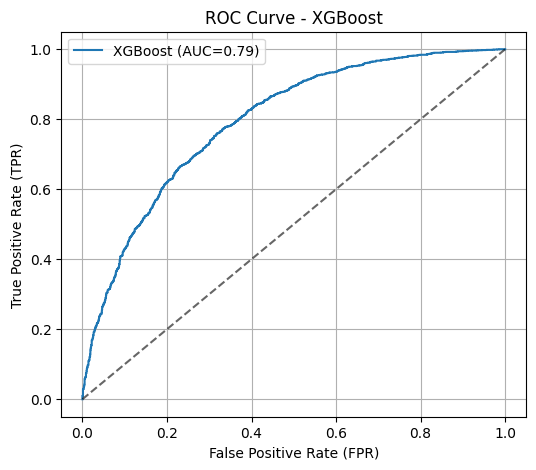

In [237]:
# model evaluation

evaluate_model(best_xgb_pipe, X_test, y_test, model_name="XGBoost")

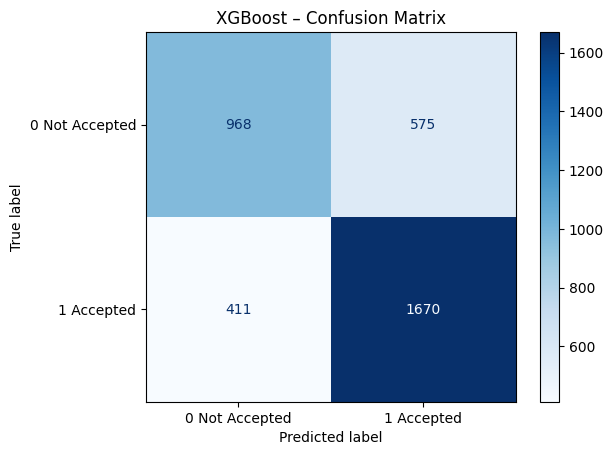

In [238]:
y_pred = best_xgb_pipe.predict(X_test)

# Confusion matrix - visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['0 Not Accepted','1 Accepted']).plot(cmap='Blues')
plt.title("XGBoost – Confusion Matrix")
plt.show()

## **2.6. CatBoost**

### **2.6.1. Model Training & Tuning & Evaluation**

In [239]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(loss_function='Logloss',
                        eval_metric='AUC',
                        verbose=False,
                        random_state=42,
                        thread_count=-1)

cb_pipe = Pipeline([('pre', preprocessor),('cb',  cb)])

# CatBoost encodes categorical variables itself, but the previous preprocessor was kept for consistency

In [240]:
cb_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_outside'],
      dtype='object'))])),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x28454ed80>)])

In [241]:
param_dist = {'cb__iterations'      : [100, 200, 300, 500, 1000],
              'cb__learning_rate'   : [0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
              'cb__depth'           : [2, 4, 6, 8, 10],
              'cb__l2_leaf_reg'     : [1, 3, 5, 7],
              'cb__bagging_temperature': [0, 0.5, 1.0],
              'cb__border_count'    : [32, 64, 128]}

In [242]:
randomsearch_cb = RandomizedSearchCV(cb_pipe,
                           param_distributions=param_dist,
                           n_iter=30,
                           cv=5,
                           scoring='f1',
                           n_jobs=1,               
                           verbose=1,
                           random_state=42)

randomsearch_cb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse_output=False),
                                                                               Index(['passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age',
       'maritalStatus', 'has_children', 'education', 'income',
       'direction_same', 'occupation_grouped', 'toCoupon_distance',
       'visit_freq', 'temp_o...
                                             ('cb',
                                              <catboost.core.CatBoostClassifier object at 0x28454ed80>)]),
                   n_iter=30, n_jobs=1,
                   param_distributions={'cb__bagging_temperature': [0, 0.5,
                                                                    1.0],
                                        'cb__border_count': [32, 64, 128],
                                        'cb__depth': [2, 4, 6, 8, 10],
                                        'cb__iterations': [100, 200, 300, 500,
                                                           1000],
                                        'cb__l2_leaf_reg': [1, 3, 5, 7],
                                        'cb__learning_rate': [0.01, 0.02, 0.05,
                                                              0.1, 0.2, 0.5]},
                   random_state=42, scoring='f1', verbose=1)

In [243]:
print("Best parameters:", randomsearch_cb.best_params_)
print("Best F1-Score (CV):", randomsearch_cb.best_score_)

Best parameters: {'cb__learning_rate': 0.02, 'cb__l2_leaf_reg': 7, 'cb__iterations': 1000, 'cb__depth': 6, 'cb__border_count': 64, 'cb__bagging_temperature': 1.0}
Best F1-Score (CV): 0.782925548349934


In [244]:
best_cb_pipe = randomsearch_cb.best_estimator_

=== CatBoost ===
Accuracy: 0.7328918322295805
F1-Score: 0.7761332099907493
ROC-AUC: 0.7998869816501676
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1543
           1       0.75      0.81      0.78      2081

    accuracy                           0.73      3624
   macro avg       0.73      0.72      0.72      3624
weighted avg       0.73      0.73      0.73      3624



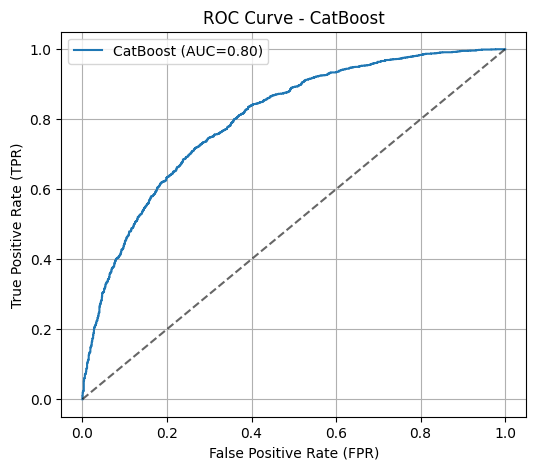

In [245]:
# model evaluation

evaluate_model(best_cb_pipe, X_test, y_test, model_name="CatBoost")

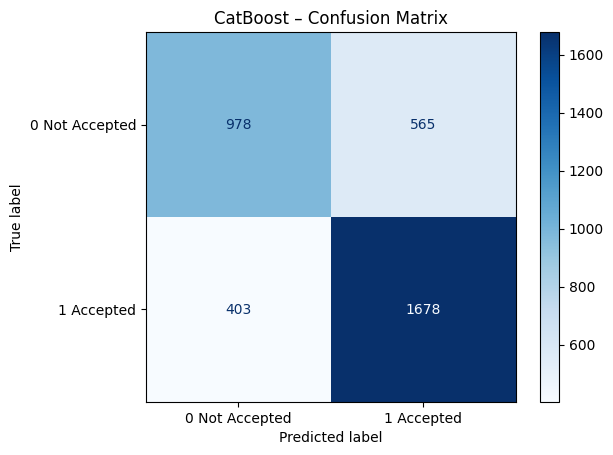

In [246]:
y_pred = best_cb_pipe.predict(X_test)

# Confusion matrix - visualization
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['0 Not Accepted','1 Accepted']).plot(cmap='Blues')
plt.title("CatBoost – Confusion Matrix")
plt.show()

## **3. Model Comparison & Conclusions**

In [247]:
results = []

models = {"Logistic Regression": lr_pipe_best,
          "Decision Tree": best_dt_pipe,
          "Random Forest": best_rf_pipe,
          "Gradient Boosting": best_gb_pipe,
          "XGBoost": best_xgb_pipe,"CatBoost": best_cb_pipe}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({"Model": name,
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "F1-Score": f1_score(y_test, y_pred),
                    "ROC-AUC": roc_auc_score(y_test, y_proba)})

results_df = pd.DataFrame(results).set_index("Model")
display(results_df)


,Accuracy,F1-Score,ROC-AUC
Model,,,
Logistic Regression,0.707506,0.759310,0.757185
Decision Tree,0.694812,0.762559,0.742136
Random Forest,0.720751,0.767142,0.782917
Gradient Boosting,0.719371,0.775348,0.783245
XGBoost,0.727925,0.772076,0.794163
CatBoost,0.732892,0.776133,0.799887


### **CatBoost** performs best in all three metrics. The model estimated with this algorithm has:
###  a) `Accuracy = 0.73`
###  b) `F1-Score = 0.78`
###  c) `ROC-AUC = 0.80`

In [248]:
# Training vs Test performance for the best model (CatBoost)

best_model = best_cb_pipe

print("\n=== TRAINING SET ===")
y_train_pred = best_model.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("F1-score:", f1_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\n=== TEST SET ===")
y_test_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1-score:", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


=== TRAINING SET ===
Accuracy: 0.8171496156120639
F1-score: 0.8450591300861896
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      3659
           1       0.81      0.88      0.85      4796

    accuracy                           0.82      8455
   macro avg       0.82      0.81      0.81      8455
weighted avg       0.82      0.82      0.82      8455


=== TEST SET ===
Accuracy: 0.7328918322295805
F1-score: 0.7761332099907493
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1543
           1       0.75      0.81      0.78      2081

    accuracy                           0.73      3624
   macro avg       0.73      0.72      0.72      3624
weighted avg       0.73      0.73      0.73      3624



### The comparison between the training and test set results **`does not indicate overfitting`**.

### The differences between training and test metrics (Accuracy / F1-Score) are moderate and expected – while the performance is slightly higher on the training data, the test set metrics remain strong. 

### It can be concluded that the model demonstrates **`good generalization ability`**, maintaining reliable predictive performance on unseen data.

In [250]:
# Feature Importance for the best model (CatBoost)

from catboost import Pool

best_cb_pipe = randomsearch_cb.best_estimator_

X_train_processed = best_cb_pipe .named_steps['pre'].transform(X_train)

feature_names = best_cb_pipe .named_steps['pre'].get_feature_names_out().tolist()

train_pool = Pool(data=X_train_processed, label=y_train, feature_names=feature_names)


model_cb = best_cb_pipe.named_steps['cb']
importances = model_cb.get_feature_importance(train_pool)

feature_importance_df = pd.DataFrame({'Feature': feature_names,'Importance': importances}).sort_values(by='Importance', ascending=False)

# top 15 features
display(feature_importance_df.head(15))


,Feature,Importance
36,onehot__visit_freq_3,9.820453
35,onehot__visit_freq_2,8.845313
12,onehot__expiration_2h,5.951999
34,onehot__visit_freq_1,5.095202
11,onehot__coupon_Restaurant(<20),4.383646
13,onehot__gender_Male,3.877513
8,onehot__coupon_Carry out & Take away,3.686188
9,onehot__coupon_Coffee House,3.236752
23,onehot__income_2,3.218083
22,onehot__education_Mid,3.054451


### **Interpretation**

### The obtained feature importance values represent **the relative contribution** of each feature to the predictive performance of the model.

### The features with the greatest impact include: `visit_freq_3`, `visit_freq_2`, `visit_freq_1`, `expiration_2h`, `coupon_Restaurant(<20)`, `coupon_Carry out & Take away`, `coupon_Coffee House`, `income_2`, `education_Mid`.

### It is worth noting that – unlike logistic regression – feature importance in CatBoost **does not indicate the direction of the effect** (whether a feature increases or decreases the probability of acceptance). Instead, it shows how strongly the model relies on each feature to make accurate predictions.